In [4]:
import numpy as np
import h5py
import pandas as pd
from scipy.linalg import sqrtm

from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, AveragePooling1D, Input, Flatten, Dropout, LeakyReLU
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L2
import tensorflow as tf

import gc

#tf.random.set_seed(59843)
#np.random.seed(59843)

tf.random.set_seed(42)
np.random.seed(42)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Load data

In [5]:
def load_exps_and_labels(detections):
    import os
    all_exps, all_labels = [], []

    for exp_name, data in detections.groupby('Exp'):
        h5_path = f'../../data/real/{exp_name}.h5'
        if not os.path.exists(h5_path):
            print(f"[WARN] File does not exist: {h5_path}")
            continue

        try:
            file = h5py.File(h5_path, 'r')
        except Exception as e:
            print(f"[ERROR] Could not load {exp_name}: {e}")
            continue

        # Read 16 channels
        try:
            channels = [file[f'Chn{ch}'][:] for ch in range(1, 17)]  # shape: list of (N, 1024)
            exp = np.stack(channels, axis=1)  # shape: (N, 16, 1024)
        except Exception as e:
            print(f"[ERROR] Failed to load or stack channels for {exp_name}: {e}")
            continue

        chirps_ids = []
        label_buffer = []

        for _, (frame_id, depth) in data[['Frame', 'Depth']].iterrows():
            chirp_indices = np.linspace(frame_id * 127, frame_id * 128 + 127, 128, dtype=np.uint16)

            # Boundary check
            chirp_indices = chirp_indices[chirp_indices < exp.shape[0]]

            chirps_ids.extend(chirp_indices)
            label_buffer.extend(np.repeat(depth, len(chirp_indices)))

        if len(chirps_ids) == 0:
            continue

        try:
            exp_selected = exp[chirps_ids]  # shape: (num_chirps, 16, 1024)
            all_exps.append(exp_selected)
            all_labels.extend(label_buffer)
        except Exception as e:
            print(f"[ERROR] Failed to index {exp_name}: {e}")
            continue

    if len(all_exps) == 0:
        raise ValueError("No valid experiments loaded.")

    try:
        all_exps = np.concatenate(all_exps, axis=0)  # shape: (total_chirps, 16, 1024)
    except Exception as e:
        raise RuntimeError(f"[FATAL] Could not stack all_exps: {e}")

    all_labels = np.array(all_labels, dtype=np.float32).reshape(-1, 1)

    # Zero out first 50 time steps
    if all_exps.shape[2] >= 50:
        all_exps[:, :, :50] = 0

    return all_exps.astype(np.float32), all_labels


In [3]:
all_detections = pd.read_csv('../data/real/TABULAR_CSV_ALL_CLASSES.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/real/TABULAR_CSV_ALL_CLASSES.csv'

In [ ]:
detections = all_detections[all_detections['Exp'].str.contains('EXP_17_')].query('Class == "Motorcycle" and Depth <= 25')

In [ ]:
# exps_train = ['EXP_17_A', 'EXP_17_B', 'EXP_17_C', 'EXP_17_D', 'EXP_17_E', 'EXP_17_F', 'EXP_17_G', 'EXP_17_H', 'EXP_17_I']
exps_train = ['EXP_17_M']

detections_train = detections.query('Exp in @exps_train')
np.unique(detections_train['Exp'])


array(['EXP_17_M'], dtype=object)

In [ ]:
# # exps_val = ['EXP_17_M', 'EXP_17_Q', 'EXP_17_L']
# exps_val = ['EXP_17_M']

# detections_val = detections.query('Exp in @exps_val')
# np.unique(detections_val['Exp'])


array(['EXP_17_L', 'EXP_17_M', 'EXP_17_Q'], dtype=object)

2025-05-16 22:16:40.971602: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-05-16 22:16:40.971671: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-16 22:16:40.971677: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-16 22:16:40.971706: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-16 22:16:40.971724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/susanli/miniconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas

[INFO] Loaded weights from: /Users/susanli/raw-radar-data-generation/paper/checkpoints/model-yam14qju/model-yam14qju-epoch-285.weights.h5


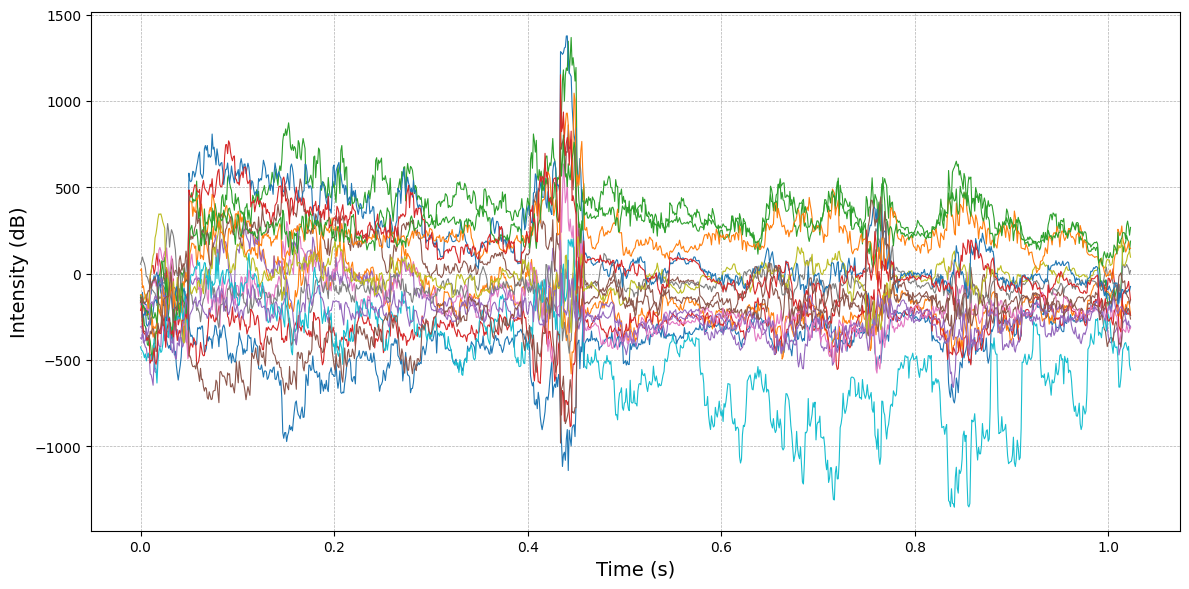

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# === Define the CWGANGP model class ===
class CWGANGP(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim, discriminator_extra_steps=3, gp_weight=10.0):
        super(CWGANGP, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, discriminator_optimizer, generator_optimizer, discriminator_loss_fn, generator_loss_fn):
        super(CWGANGP, self).compile()
        self.d_optimizer = discriminator_optimizer
        self.g_optimizer = generator_optimizer
        self.d_loss_fn = discriminator_loss_fn
        self.g_loss_fn = generator_loss_fn

# === Build the generator ===
def build_generator():
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import InputLayer, Dense, Reshape, Conv1DTranspose, ReLU

    model = Sequential([
        InputLayer((101,)),
        Dense(4 * 256),
        Reshape([4, 256]),
        ReLU(),
        Conv1DTranspose(128, kernel_size=25, strides=4, padding='same', activation='relu'),
        Conv1DTranspose(64, kernel_size=25, strides=4, padding='same', activation='relu'),
        Conv1DTranspose(32, kernel_size=25, strides=4, padding='same', activation='relu'),
        Conv1DTranspose(16, kernel_size=25, strides=4, padding='same', activation='tanh'),
    ])
    return model

# === Build the discriminator ===
def build_discriminator():
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import InputLayer, Conv1D, LeakyReLU, Flatten, Dense

    model = Sequential([
        InputLayer((1024, 17)),
        Conv1D(32, kernel_size=25, strides=4, padding='same'),
        LeakyReLU(0.2),
        Conv1D(64, kernel_size=25, strides=4, padding='same'),
        LeakyReLU(0.2),
        Conv1D(128, kernel_size=25, strides=4, padding='same'),
        LeakyReLU(0.2),
        Conv1D(256, kernel_size=25, strides=4, padding='same'),
        LeakyReLU(0.2),
        Flatten(),
        Dense(1, activation='linear'),
    ])
    return model

# === Full GAN builder ===
def build_gan():
    generator = build_generator()
    discriminator = build_discriminator()
    gan = CWGANGP(discriminator, generator, latent_dim=100, discriminator_extra_steps=5)
    gan.compile(
        discriminator_optimizer=tf.keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9),
        generator_optimizer=tf.keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9),
        discriminator_loss_fn=lambda real_img, fake_img: tf.reduce_mean(fake_img) - tf.reduce_mean(real_img),
        generator_loss_fn=lambda fake_img: -tf.reduce_mean(fake_img)
    )
    return gan

# === Load and build model ===
gan = build_gan()
weights_path = '/Users/susanli/raw-radar-data-generation/paper/checkpoints/model-yam14qju/model-yam14qju-epoch-285.weights.h5'

# Build generator/discriminator by running dummy input through them
latent = tf.random.normal((1, 100))
label = tf.zeros((1, 1))
gen_input = tf.concat([latent, label], axis=1)
fake_signal = gan.generator(gen_input)
disc_input = tf.concat([fake_signal, tf.zeros((1, 1024, 1))], axis=2)
_ = gan.discriminator(disc_input)

# Load weights
gan.build([(None, 1024, 17), (None, 101)])  # or any placeholder input shapes
gan.load_weights(weights_path)

generator = gan.generator
print(f"[INFO] Loaded weights from: {weights_path}")

# === Generate a sample ===
label_value = 10.0  # depth in meters
label = tf.constant([[label_value]], dtype=tf.float32)
label = (label - 10.981254577636719) / 7.1911773681640625  # normalization
latent = tf.random.normal((1, 100))
input_vector = tf.concat([latent, label], axis=1)

generated = generator(input_vector, training=False)[0].numpy()  # shape: (1024, 16)

# === Denormalize ===
a, b = -1, 1
data_min, data_max = -2444.0, 2544.0
signal = data_min + (generated - a) * (data_max - data_min) / (b - a)

# === Plot ===
time = np.arange(signal.shape[0]) / 1000  # assuming 1 kHz sampling

plt.figure(figsize=(12, 6))
for ch in range(signal.shape[1]):
    plt.plot(time, signal[:, ch], linewidth=0.8)

plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Intensity (dB)", fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig("generated_traces.png", dpi=300)
plt.show()


In [7]:
import h5py
import numpy as np

# Load .h5 file
h5_path = '/Users/susanli/raw-radar-data-generation/paper/data/real/EXP_17_M.h5'
with h5py.File(h5_path, 'r') as f:
    # Load all 16 channels for one frame (e.g., frame 0)
    channels = [f[f'Chn{i+1}'][:] for i in range(16)]  # shape: list of (6144, 1024)
    data = np.stack(channels, axis=1)  # shape: (6144, 16, 1024)

# Extract chirps from one frame
frame_id = 0
chirp_indices = np.arange(frame_id * 128, (frame_id + 1) * 128)
real_frame = data[chirp_indices]  # shape: (128, 16, 1024)

# Compute RA map via FFT
# FFT across chirps (axis=0) → range-azimuth plane
ra_map_real = np.abs(np.fft.fftshift(np.fft.fft2(real_frame, axes=(0, 2)), axes=0))
ra_map_real_db = 20 * np.log10(np.clip(ra_map_real.mean(axis=1), a_min=1e-6, a_max=None))  # shape: (128, 1024)


In [8]:
# === Generate signal ===
latent = tf.random.normal((1, 100))
label = tf.constant([[10.0]], dtype=tf.float32)
label = (label - 10.981254577636719) / 7.1911773681640625
gen_input = tf.concat([latent, label], axis=1)
generated = generator(gen_input, training=False)[0].numpy()  # (1024, 16)

# Repeat over 128 chirps to simulate a frame
generated_frame = np.repeat(generated[np.newaxis, :, :], 128, axis=0)  # (128, 1024, 16)
generated_frame = np.transpose(generated_frame, (0, 2, 1))  # (128, 16, 1024)

# Compute RA map via FFT
ra_map_fake = np.abs(np.fft.fftshift(np.fft.fft2(generated_frame, axes=(0, 2)), axes=0))
ra_map_fake_db = 20 * np.log10(np.clip(ra_map_fake.mean(axis=1), a_min=1e-6, a_max=None))  # shape: (128, 1024)


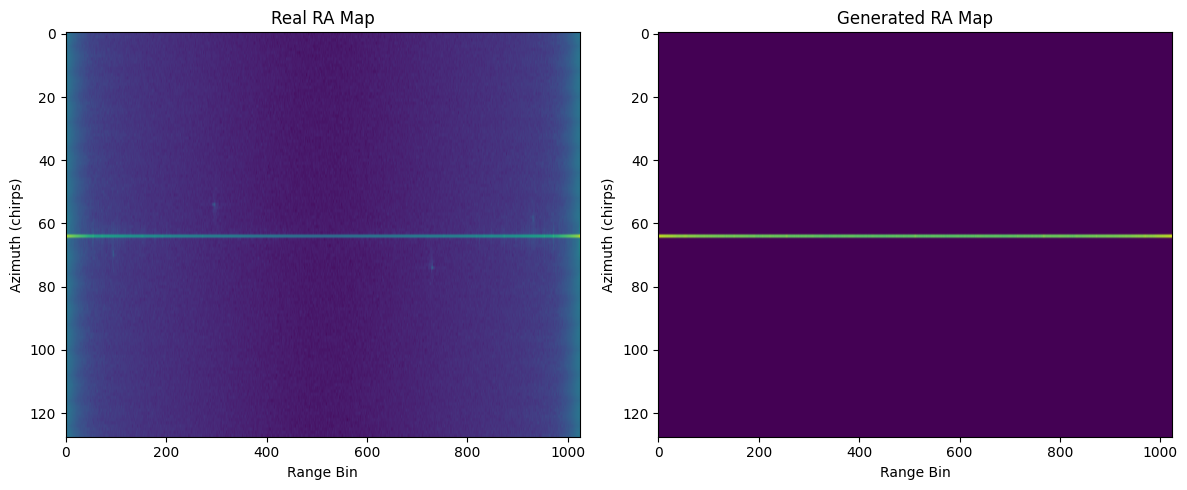

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(ra_map_real_db, aspect='auto', cmap='viridis')
plt.title("Real RA Map")
plt.xlabel("Range Bin")
plt.ylabel("Azimuth (chirps)")

plt.subplot(1, 2, 2)
plt.imshow(ra_map_fake_db, aspect='auto', cmap='viridis')
plt.title("Generated RA Map")
plt.xlabel("Range Bin")
plt.ylabel("Azimuth (chirps)")

plt.tight_layout()
plt.savefig("ra_maps_comparison.png", dpi=300)
plt.show()


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

# Add absolute path to src/ so imports work
sys.path.append(os.path.join(os.getcwd(), 'src'))

from src import Signal_Processing as sp
from src import bsd_lib as bsd

# === Config ===
file_real = "/Users/susanli/raw-radar-data-generation/paper/data/real/EXP_17_M.h5"
file_generated = "/Users/susanli/raw-radar-data-generation/paper/data/generated/sample.npy"  # << update this
output_dir = "/Users/susanli/raw-radar-data-generation/paper/plots/generated_ra"
ra_output_npy = "/Users/susanli/raw-radar-data-generation/paper/data/generated/generation_ra.npy"
os.makedirs(output_dir, exist_ok=True)

# === Load GAN-generated signals ===
# Expect shape: (num_frames, 1024, 16)
generated_data = np.load(file_generated)
print("[INFO] Loaded generated data:", generated_data.shape)

# === Setup radar processor ===
radar = sp.Radar_Cube(file_real, dmax=30)
detector = bsd.BlindspotDetector(radar)

# Ensure radar processing is initialized
radar.gen_Cube(0)
radar._attrs['nLoop'] = 1  # Important for range_Profile()

# === Process each generated frame ===
ra_imgs = []
for i, frame in enumerate(generated_data):
    print(f"[INFO] Processing frame {i+1}/{len(generated_data)}")

    radar.range_Profile(frame)  # Provide one (1024, 16) frame
    RAimg = radar.range_Azimuth()['Data']  # Extract RA image (2D)

    ra_imgs.append(RAimg)

    # === Optional: save as image
    plt.figure(figsize=(10, 6))
    plt.imshow(RAimg, aspect='auto', cmap='viridis')
    plt.title(f"Generated RA Map - Frame {i}")
    plt.xlabel("Range Bin")
    plt.ylabel("Azimuth Bin")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/frame_{i:03d}.png")
    plt.close()

# === Save all RA maps as .npy for later use
ra_imgs = np.array(ra_imgs)
np.save(ra_output_npy, ra_imgs)
print(f"[DONE] Saved all RA maps to: {ra_output_npy}")


[INFO] Loaded generated data: (6000, 16, 1024)
[INFO] Processing frame 1/6000
[INFO] Processing frame 2/6000
[INFO] Processing frame 3/6000
[INFO] Processing frame 4/6000
[INFO] Processing frame 5/6000
[INFO] Processing frame 6/6000
[INFO] Processing frame 7/6000
[INFO] Processing frame 8/6000
[INFO] Processing frame 9/6000
[INFO] Processing frame 10/6000
[INFO] Processing frame 11/6000
[INFO] Processing frame 12/6000
[INFO] Processing frame 13/6000
[INFO] Processing frame 14/6000
[INFO] Processing frame 15/6000
[INFO] Processing frame 16/6000
[INFO] Processing frame 17/6000
[INFO] Processing frame 18/6000
[INFO] Processing frame 19/6000
[INFO] Processing frame 20/6000
[INFO] Processing frame 21/6000
[INFO] Processing frame 22/6000
[INFO] Processing frame 23/6000
[INFO] Processing frame 24/6000
[INFO] Processing frame 25/6000
[INFO] Processing frame 26/6000
[INFO] Processing frame 27/6000
[INFO] Processing frame 28/6000
[INFO] Processing frame 29/6000
[INFO] Processing frame 30/6000
[I

In [21]:
import numpy as np

ra_maps = np.load('/Users/susanli/raw-radar-data-generation/paper/data/generated/generation_ra.npy')  # adjust path as needed
print("RA map shape:", ra_maps.shape)


RA map shape: (6000, 333, 128)


In [22]:
import os
os.makedirs('/Users/susanli/raw-radar-data-generation/paper/plots/generated_ra', exist_ok=True)

for i in range(ra_maps.shape[0]):
    plt.imsave(f'./plots/generated_ra/frame_{i:04d}.png', ra_maps[i], cmap='viridis')


In [14]:
import numpy as np

generated = np.load('/Users/susanli/raw-radar-data-generation/paper/data/generated/generation_ra.npy')
print("Shape:", generated.shape)


Shape: (6000, 333, 128)


In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from src.Signal_Processing import Radar_Cube
from src.bsd_lib import BlindspotDetector

# === Config ===
file_real = '/Users/susanli/raw-radar-data-generation/paper/data/real/EXP_17_M.h5'
output_dir = '/Users/susanli/raw-radar-data-generation/paper/plots/real_ra'
ra_output_npy = '/Users/susanli/raw-radar-data-generation/paper/data/real/real_ra.npy'
os.makedirs(output_dir, exist_ok=True)

# === Initialize radar processor ===
radar = Radar_Cube(file_real, dmax=30)
detector = BlindspotDetector(radar)

radar.gen_Cube(0)
radar._attrs['nLoop'] = 1  # needed for range_Profile

# === Generate RA maps from real radar frames ===
n_frames = int(radar._attrs['maxFrm'])  # total number of frames in the file
print(f"[INFO] Total frames in file: {n_frames}")

ra_maps = []

for frame_id in range(n_frames):
    print(f"[INFO] Processing frame {frame_id+1}/{n_frames}")

    try:
        radar.gen_Cube(frame_id)  # load one radar cube
        RP = radar.range_Profile()['Data']  # (128, 16, 1024)
        RAimg = radar.range_Azimuth()['Data']  # (Azimuth, Range)

        ra_maps.append(RAimg)

        # === Optional: save image
        plt.imsave(f"{output_dir}/frame_{frame_id:04d}.png", RAimg, cmap='viridis')
    except Exception as e:
        print(f"[WARN] Skipping frame {frame_id}: {e}")

# === Save all RA maps as .npy file
ra_maps = np.array(ra_maps)
np.save(ra_output_npy, ra_maps)
print(f"[DONE] Saved {len(ra_maps)} RA maps to: {ra_output_npy}")


[INFO] Total frames in file: 113
[INFO] Processing frame 1/113
[INFO] Processing frame 2/113
[INFO] Processing frame 3/113
[INFO] Processing frame 4/113
[INFO] Processing frame 5/113
[INFO] Processing frame 6/113
[INFO] Processing frame 7/113
[INFO] Processing frame 8/113
[INFO] Processing frame 9/113
[INFO] Processing frame 10/113
[INFO] Processing frame 11/113
[INFO] Processing frame 12/113
[INFO] Processing frame 13/113
[INFO] Processing frame 14/113
[INFO] Processing frame 15/113
[INFO] Processing frame 16/113
[INFO] Processing frame 17/113
[INFO] Processing frame 18/113
[INFO] Processing frame 19/113
[INFO] Processing frame 20/113
[INFO] Processing frame 21/113
[INFO] Processing frame 22/113
[INFO] Processing frame 23/113
[INFO] Processing frame 24/113
[INFO] Processing frame 25/113
[INFO] Processing frame 26/113
[INFO] Processing frame 27/113
[INFO] Processing frame 28/113
[INFO] Processing frame 29/113
[INFO] Processing frame 30/113
[INFO] Processing frame 31/113
[INFO] Processi

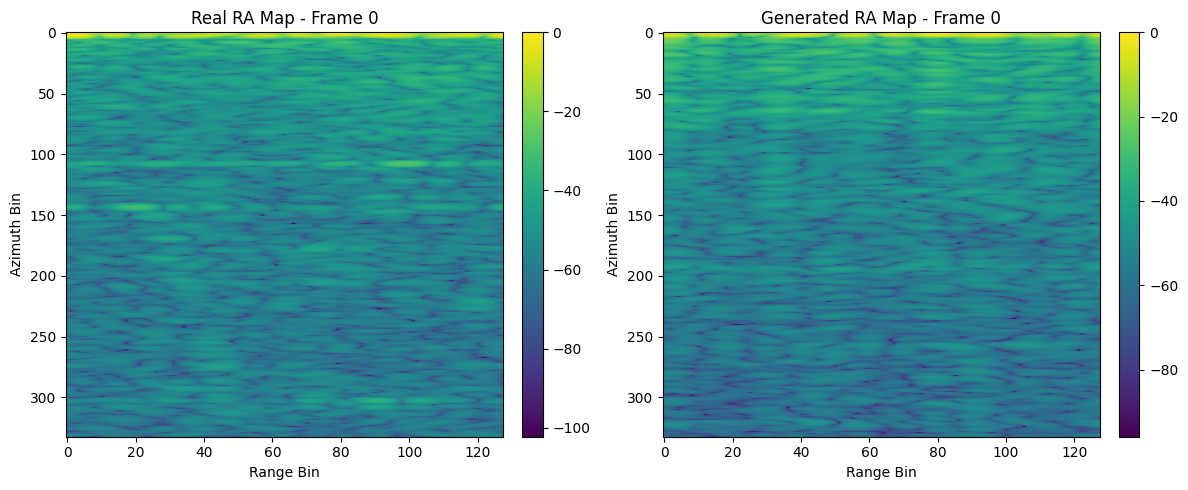

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# === Load precomputed RA maps ===
real_ra = np.load('/Users/susanli/raw-radar-data-generation/paper/data/real/real_ra.npy')            # shape: (N, A, R)
gen_ra = np.load('/Users/susanli/raw-radar-data-generation/paper/data/generated/generation_ra.npy')  # shape: (N, A, R)

# === Select frame to compare ===
frame_id = 0  # choose any frame index (0 <= frame_id < N)

real_img = real_ra[frame_id]
gen_img = gen_ra[frame_id]

# === Plot comparison ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(real_img, aspect='auto', cmap='viridis')
axes[0].set_title(f"Real RA Map - Frame {frame_id}")
axes[0].set_xlabel("Range Bin")
axes[0].set_ylabel("Azimuth Bin")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(gen_img, aspect='auto', cmap='viridis')
axes[1].set_title(f"Generated RA Map - Frame {frame_id}")
axes[1].set_xlabel("Range Bin")
axes[1].set_ylabel("Azimuth Bin")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(f"/Users/susanli/raw-radar-data-generation/paper/plots/comparison_ra/frame_{frame_id:04d}_compare.png", dpi=300)
plt.show()


In [30]:
print("Real RA map shape:", real_ra.shape)
print("Generated RA map shape:", gen_ra.shape)
print("Real RA map shape:", real_img.shape)
print("Generated RA map shape:", gen_img.shape)


Real RA map shape: (113, 333, 128)
Generated RA map shape: (6000, 333, 128)
Real RA map shape: (333, 128)
Generated RA map shape: (333, 128)


In [ ]:
raw_data = np.load(f'/Users/susanli/raw-radar-data-generation/paper/data/generated/sample.npy')
len(raw_data)

6000

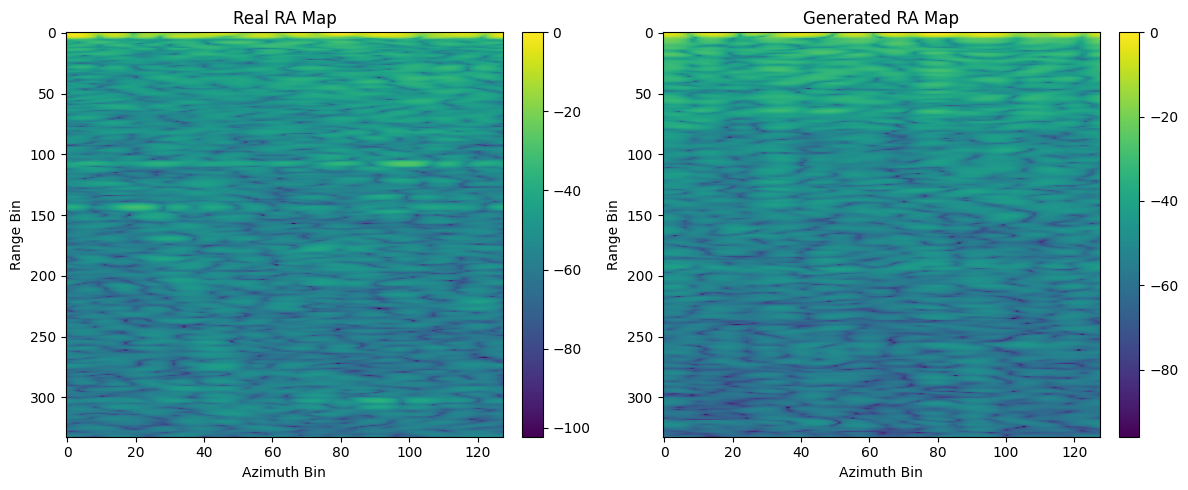

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import os

# === Load data
real_ra = np.load('/Users/susanli/raw-radar-data-generation/paper/data/real/real_ra.npy')            # shape: (N, A, R)
gen_ra = np.load('/Users/susanli/raw-radar-data-generation/paper/data/generated/generation_ra.npy')  # shape: (N, A, R)

# === Choose frame index
frame_id = 0  # still selecting the frame, just not showing it in the title

real_img = real_ra[frame_id]
gen_img = gen_ra[frame_id]

# === Output directory
os.makedirs("./plots/comparison_ra", exist_ok=True)

# === Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(real_img, aspect='auto', cmap='viridis')
axes[0].set_title("Real RA Map")  # No frame number
axes[0].set_xlabel("Azimuth Bin")
axes[0].set_ylabel("Range Bin")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(gen_img, aspect='auto', cmap='viridis')
axes[1].set_title("Generated RA Map")  # No frame number
axes[1].set_xlabel("Azimuth Bin")
axes[1].set_ylabel("Range Bin")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(f"./plots/comparison_ra/frame_{frame_id:04d}_compare_clean.png", dpi=300)
plt.show()


In [ ]:
from src import Signal_Processing as sp
PATH = "/Users/susanli/raw-radar-data-generation/paper/data/real/"
file = PATH + "EXP_17_M.h5"
radar = sp.Radar_Cube(file, dmax=30)


for k, v in radar._attrs.items():
    print(f"{k}")

channels: ['Chn1', 'Chn2', 'Chn3', 'Chn4', 'Chn5', 'Chn6', 'Chn7', 'Chn8', 'Chn9', 'Chn10', 'Chn11', 'Chn12', 'Chn13', 'Chn14', 'Chn15', 'Chn16']
fStart: 76000000000.0
fStop: 77000000000.0
nLoop: 128
n: 1024
tRampUp: 6.144e-05
tRampDown: 1.6e-05
calIm: [ 4607302130007539712 -4622214346922000384 -4623596067965894656
 -4621608207851192320  4606896391694843904  4593303090249072640
  4604547199739625472 -4625583171092611072  4605285385432465408
 -4628122235498921984 -4618237379004596224 -4636544747970756608
 -4620051218855624704  4600761303106060288 -4628880756788166656
                    0]
calRe: [ 4594941819988475904  4603828363948195840 -4618649652915339264
 -4614857345506213888  4592937863410089984  4606426734873542656
 -4622176057288556544 -4618670481896112128 -4661514785886568448
  4605763303623360512 -4644594401446723584  4606650035055099904
  4603090277039603712  4607838672354541568 -4615655310432927744
  4607182418800017408]
fusca: 1.3761635406564715e-05
fs: 20000000.0
NrChn: 16

In [ ]:
import h5py

# Path to your file
h5_path = '/Users/susanli/raw-radar-data-generation/paper/data/real/EXP_17_M.h5'

# Open and inspect
with h5py.File(h5_path, 'r') as f:
    # List all datasets in the file
    print("Datasets:")
    for key in f.keys():
        print(f"  {key}: shape = {f[key].shape}")

    # Example: get shape of channel 1
    shape = f['Chn1'].shape
    print("\nShape of Chn1:", shape)


Datasets:
  Camera2: shape = (451584, 376)
  Camera2Time_ms: shape = (112,)
  Chn1: shape = (14464, 1024)
  Chn10: shape = (14464, 1024)
  Chn11: shape = (14464, 1024)
  Chn12: shape = (14464, 1024)
  Chn13: shape = (14464, 1024)
  Chn14: shape = (14464, 1024)
  Chn15: shape = (14464, 1024)
  Chn16: shape = (14464, 1024)
  Chn2: shape = (14464, 1024)
  Chn3: shape = (14464, 1024)
  Chn4: shape = (14464, 1024)
  Chn5: shape = (14464, 1024)
  Chn6: shape = (14464, 1024)
  Chn7: shape = (14464, 1024)
  Chn8: shape = (14464, 1024)
  Chn9: shape = (14464, 1024)
  ChnTime: shape = (113,)

Shape of Chn1: (14464, 1024)


In [ ]:
# exps_val2 = ['EXP_17_M']
# #exps_val2 = ['EXP_17_R']

# detections_val2 = detections.query('Exp in @exps_val2')
# np.unique(detections_val2['Exp'])


array(['EXP_17_P', 'EXP_17_R'], dtype=object)

In [ ]:
print(detections_train['Exp'].unique())


['EXP_17_M']


In [ ]:
X_train, y_train = load_exps_and_labels(detections_train)


[WARN] File does not exist: ../../data/real/EXP_17_M.h5


ValueError: No valid experiments loaded.

In [ ]:
X_train, y_train = load_exps_and_labels(detections_train)
X_val, y_val = load_exps_and_labels(detections_val)
X_val2, y_val2 = load_exps_and_labels(detections_val2)

ValueError: No valid experiments loaded.

In [ ]:
X_train.shape

(48256, 16, 1024)

In [ ]:
X_val.shape

(12416, 16, 1024)

In [ ]:
X_val2.shape

(15616, 16, 1024)

# Preprocess data

## Swap axis

In [ ]:
X_train = np.swapaxes(X_train, 2, 1)
X_val = np.swapaxes(X_val, 2, 1)
X_val2 = np.swapaxes(X_val2, 2, 1)

## Scale

In [ ]:
X_mean = 183.12559509277344
X_std = 973.3739013671875

In [ ]:
X_train = np.subtract(X_train, X_mean, out=X_train)
X_train = np.divide(X_train, X_std, out=X_train)

In [ ]:
X_val = np.subtract(X_val, X_mean, out=X_val)
X_val = np.divide(X_val, X_std, out=X_val)

In [ ]:
X_val2 = np.subtract(X_val2, X_mean, out=X_val2)
X_val2 = np.divide(X_val2, X_std, out=X_val2)

## Shuffle

In [ ]:
random_ids = np.arange(len(X_train))
np.random.shuffle(random_ids)

X_train[:, :, :] = X_train[random_ids]
y_train[:, :] = y_train[random_ids]

# Build Model

In [ ]:
model = Sequential([
    Input((1024, 16)),
    Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=L2(0.5)),
    AveragePooling1D(strides=4),
    Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=L2(0.5)),
    AveragePooling1D(strides=4),
    Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=L2(0.5)),
    AveragePooling1D(strides=4),
    Flatten(),
    Dense(1, activation='linear', kernel_regularizer=L2(0.5))
])

2022-08-25 10:33:48.880475: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-25 10:33:48.910415: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2599990000 Hz
2022-08-25 10:33:48.911034: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ee191e0960 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-25 10:33:48.911051: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-25 10:33:48.979249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 32)          1568      
_________________________________________________________________
average_pooling1d (AveragePo (None, 256, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 254, 64)           6208      
_________________________________________________________________
average_pooling1d_1 (Average (None, 64, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 62, 128)           24704     
_________________________________________________________________
average_pooling1d_2 (Average (None, 16, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [ ]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=[RootMeanSquaredError()])

# Train Model

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=5,
                    batch_size=128)

2022-08-25 10:33:51.457480: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 3162505216 exceeds 10% of free system memory.


Epoch 1/5


2022-08-25 10:33:53.991261: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-08-25 10:33:54.302434: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2022-08-25 10:33:55.628499: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2022-08-25 10:33:55.781252: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-08-25 10:33:59.815961: I tensorflow/stream_executor/cuda/cuda_driver.cc:775] failed to allocate 3.34G (3586195456 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-08-25 10:33:59.815992: W tensorflow/core/common_runtime/bfc_allocator.cc:312] Garbage collection: deallocate free memory regions (i.e.,

374/377 [============================>.] - ETA: 0s - loss: 64.6959 - root_mean_squared_error: 6.4575

2022-08-25 10:34:09.592987: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 813694976 exceeds 10% of free system memory.


377/377 [==============================] - 6s 16ms/step - loss: 64.5220 - root_mean_squared_error: 6.4525 - val_loss: 55.2353 - val_root_mean_squared_error: 6.7857
Epoch 2/5
377/377 [==============================] - 5s 13ms/step - loss: 41.4423 - root_mean_squared_error: 5.7635 - val_loss: 31.4088 - val_root_mean_squared_error: 4.8064
Epoch 3/5
377/377 [==============================] - 4s 12ms/step - loss: 33.9936 - root_mean_squared_error: 5.0184 - val_loss: 30.5574 - val_root_mean_squared_error: 4.6524
Epoch 4/5
377/377 [==============================] - 5s 12ms/step - loss: 31.3834 - root_mean_squared_error: 4.7112 - val_loss: 27.6166 - val_root_mean_squared_error: 4.2758
Epoch 5/5
377/377 [==============================] - 5s 12ms/step - loss: 30.6520 - root_mean_squared_error: 4.6167 - val_loss: 26.0922 - val_root_mean_squared_error: 4.0646


In [ ]:
del X_train
del y_train
gc.collect()

1476

# FID Socore

In [ ]:
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if np.iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
	
	return fid

In [ ]:
model.pop()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 32)          1568      
_________________________________________________________________
average_pooling1d (AveragePo (None, 256, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 254, 64)           6208      
_________________________________________________________________
average_pooling1d_1 (Average (None, 64, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 62, 128)           24704     
_________________________________________________________________
average_pooling1d_2 (Average (None, 16, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

## Evaluation 1

In [ ]:
X_val2.shape
#np.random.shuffle(X_val)

(15616, 1024, 16)

In [ ]:
calculate_fid(model, X_val2[:10000], X_val[:10000])

3.3107304181197956

In [ ]:
noise = np.random.randn(10000, 1024, 16)
calculate_fid(model, X_val[:10000], noise)

66.37212836771631

: 

In [ ]:
generations = np.load('../data/generated/conditional-nooutliers-1-15616samples.npy')
generations = np.swapaxes(generations, 2, 1)

In [ ]:
generations.shape

(15616, 1024, 16)

In [ ]:
generations_scaled = np.subtract(generations, X_mean, out=generations)
generations_scaled = np.divide(generations_scaled, X_std, out=generations_scaled)
np.random.shuffle(generations_scaled)

In [ ]:
calculate_fid(model, X_val2[:10000], generations_scaled[:10000])

3.276240066979539

In [ ]:
exp_17_m = np.load('../data/preprocessed/EXP_17_M_chirps.npy')
exp_17_m = np.swapaxes(exp_17_m, 2, 1)

In [ ]:
exp_17_m.shape

(6144, 1024, 16)

In [ ]:
exp_17_m_scaled = np.subtract(exp_17_m, X_mean, out=exp_17_m)
exp_17_m_scaled = np.divide(exp_17_m_scaled, X_std, out=exp_17_m_scaled)
np.random.shuffle(exp_17_m_scaled)

In [ ]:
calculate_fid(model, exp_17_m_scaled[:3000], exp_17_m_scaled[3000:6000])

0.010722588448832504

In [ ]:
calculate_fid(model, exp_17_m_scaled[:6000], generations_scaled[:6000])

1.1979097538933017

## Evaluation 2

In [ ]:
generations = np.load('../data/generated/conditional-nooutliers-1-3000samples.npy')
generations = np.swapaxes(generations, 2, 1)

In [ ]:
generations.shape, generations.mean(), generations.std(), generations.min(), generations.max()

((3000, 1024, 16), 183.87898, 985.5411, -3372.0, 4300.0)

In [ ]:
generations_scaled = np.subtract(generations, X_mean, out=generations)
generations_scaled = np.divide(generations_scaled, X_std, out=generations_scaled)
np.random.shuffle(generations_scaled)

In [ ]:
train = np.load('../data/preprocessed/EXP_17_M_chirps.npy')
train = np.swapaxes(train, 2, 1)

In [ ]:
train.shape, train.mean(), train.std(), train.min(), train.max()

((6144, 1024, 16), 183.6147, 1001.003, -3884.0, 4772.0)

In [ ]:
train_scaled = np.subtract(train, X_mean, out=train)
train_scaled = np.divide(train_scaled, X_std, out=train_scaled)
np.random.shuffle(train_scaled)

In [ ]:
test = np.load('../data/preprocessed/EXP_17_R_chirps.npy')
test = np.swapaxes(test, 2, 1)

In [ ]:
test.shape, test.mean(), test.std(), test.min(), test.max()

((9984, 1024, 16), 176.87022, 950.60364, -3056.0, 3412.0)

In [ ]:
test_scaled = np.subtract(test, X_mean, out=test)
test_scaled = np.divide(test_scaled, X_std, out=test_scaled)
np.random.shuffle(test_scaled)

In [ ]:
calculate_fid(model, train, test)

2022-08-25 10:35:52.458916: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 402653184 exceeds 10% of free system memory.


10.573613168012267

In [ ]:
calculate_fid(model, test[:3000], train[:3000])

10.425674584971656

In [ ]:
calculate_fid(model, train[:len(train)//2], train[len(train)//2:])

0.05398092000254107

In [ ]:
calculate_fid(model, test[:len(test)//2], test[len(test)//2:])

0.014454785789405237

In [ ]:
calculate_fid(model, generations, train[:len(generations)])

1.0992568604468582

In [ ]:
calculate_fid(model, generations, test[:len(generations)])

7.924173031070388